In [1]:
! git clone https://github.com/ThangNgXuan/Udacity-Self-Driving-Car-Simulator.git

Cloning into 'Udacity-Self-Driving-Car-Simulator'...
remote: Enumerating objects: 15989, done.
remote: Counting objects: 100% (15989/15989), done.
remote: Compressing objects: 100% (15989/15989), done.
remote: Total 15989 (delta 0), reused 15989 (delta 0), pack-reused 0
Receiving objects: 100% (15989/15989), 233.85 MiB | 30.18 MiB/s, done.
Checking out files: 100% (16015/16015), done.


In [2]:
ls Udacity-Self-Driving-Car-Simulator

ls: cannot access 'track': No such file or directory


In [3]:
!pip install imgaug

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import pandas as pd
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
%matplotlib inline

In [5]:
datadir = 'Udacity-Self-Driving-Car-Simulator'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', None)
data.head()

center  ...     speed
0  C:\Users\ASUS\Desktop\Data\IMG\center_2021_09_30_14_49_56_539.jpg  ...  0.000079
1  C:\Users\ASUS\Desktop\Data\IMG\center_2021_09_30_14_49_56_643.jpg  ...  0.000079
2  C:\Users\ASUS\Desktop\Data\IMG\center_2021_09_30_14_49_56_747.jpg  ...  0.000079
3  C:\Users\ASUS\Desktop\Data\IMG\center_2021_09_30_14_49_56_849.jpg  ...  0.000078
4  C:\Users\ASUS\Desktop\Data\IMG\center_2021_09_30_14_49_56_952.jpg  ...  0.000082

[5 rows x 7 columns]

In [6]:
# tách đường dẫn chỉ giữ lại tên image
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2021_09_30_14_49_56_539.jpg  ...  0.000079
1  center_2021_09_30_14_49_56_643.jpg  ...  0.000079
2  center_2021_09_30_14_49_56_747.jpg  ...  0.000079
3  center_2021_09_30_14_49_56_849.jpg  ...  0.000078
4  center_2021_09_30_14_49_56_952.jpg  ...  0.000082

[5 rows x 7 columns]

[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


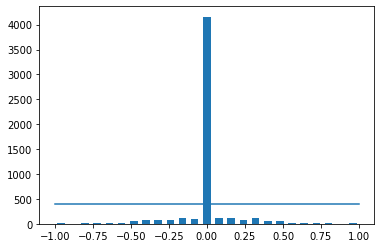

In [7]:
# biểu đồ histogram hiển thị steering angle
num_bins = 25
# chia histogram thành 25 cột steering angle
# lưu ý các cột chỉ tương ứng với giá trị chia đều của steering angle, không phải là giá trị steering angle của data
hist, bins = np.histogram(data['steering'], num_bins)
samples_per_bin = 400
# vì bins không có giá trị 0 (go straight) nên phải cộng 2 ma trận để tạo ra số 0 và phải chia đôi vì giá trị steering đã gấp đôi
center = (bins[:-1] + bins[1:]) * 0.5
print(center)
plt.bar(center, hist, width=0.05) # width là độ rộng của cột
# vẽ 1 đường thẳng cắt giá trị lớn hơn 200
# plt.plot((x1,x2), (y1,y2))
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 5338
Removed: 3759
Remaining: 1579


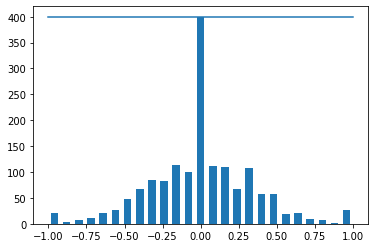

In [8]:
remove_list = []
print('Total data:', len(data))
# 2 vòng for chạy hết tất cả các phần tử của steering angle
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        # các steering angle nằm giữa 2 bin sẽ được gộp lại thành 1 bin 
        # i là index của steering angle trong data['steering']
        # sẽ gộp hết tất cả index của các steering angle của từng cột bin thành 1 list
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)  # shuffle list để không bị mất information khi train 
    list_ = list_[samples_per_bin:] # gán list cho list nào có 200 phần tử trở lên
    remove_list.extend(list_)  # remove_list chứa các index của data['steering'] cần được loại bỏ
print('Removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)  # xóa hết các steering anlge có index nằm trong remove_list của file data ban đầu
print('Remaining:', len(data))
hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05) 
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [9]:
print(data.iloc[0])
def load_img_steering(datadir, data):
    image_path = [] # image_path là array chứa đường dẫn của image (samples)
    steering = []   # steering là array chứa label tương ứng với image đó
    for i in range(len(data)):
        indexed_data = data.iloc[i] #data.iloc[i] là gán giá trị theo index theo hàng(row) ví dụ index[0] = center, index[1] = left
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip())) # center.strip xóa dấu cách của đường dẫn
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings
image_paths, steerings = load_img_steering(os.path.join(datadir+'/IMG'), data)

center      center_2021_09_30_14_49_57_667.jpg
left          left_2021_09_30_14_49_57_667.jpg
right        right_2021_09_30_14_49_57_667.jpg
steering                                     0
throttle                                     1
reverse                                      0
speed                                  2.80536
Name: 11, dtype: object


In [10]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training samples:{}\nValidation samples:{}'.format(len(X_train),len(X_val)))

Training samples:3789
Validation samples:948


Text(0.5, 1.0, 'Validation set')

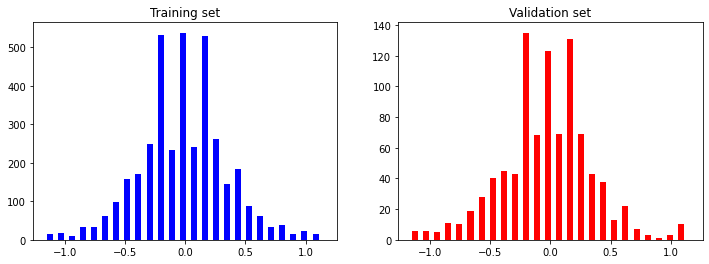

In [11]:
# plot histogram so sánh sự cân bằng data giữa traing và validation set
fig, ax = plt.subplots(1,2,figsize=(12,4)) # 1 row 2 column
ax[0].hist(y_train, bins=num_bins, width=0.05, color='b')
ax[0].set_title('Training set')
ax[1].hist(y_val, bins=num_bins, width=0.05, color='r')
ax[1].set_title('Validation set')

In [12]:
# thực hiện data augmentation technique
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.3))  # zoom in ngẫu nhiên từ 0% đến 30%
  image = zoom.augment_image(image)
  return image

Text(0.5, 1.0, 'Zoomed image')

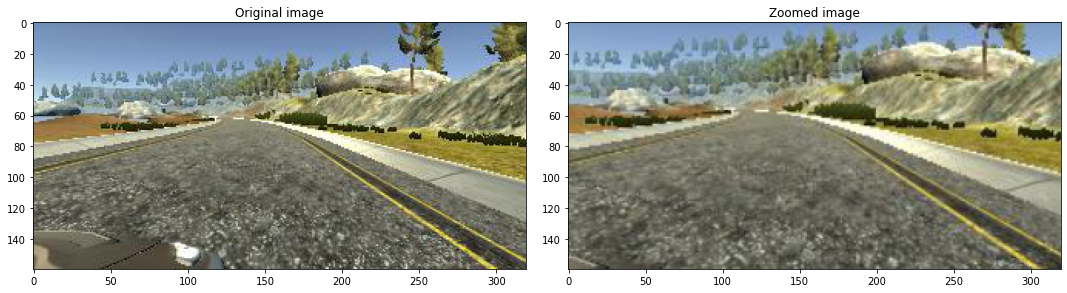

In [13]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomd_image = zoom(original_image)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
plt.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title('Original image')
ax[1].imshow(zoomd_image)
ax[1].set_title('Zoomed image')

In [14]:
def pan(image):
  # dịch ảnh qua trái hoặc qua phải theo trục x và trục y đi 10%
  pan = iaa.Affine(translate_percent={'x':(-0.1, 0.1), 'y':(-0.1, 0.1)}) 
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned image')

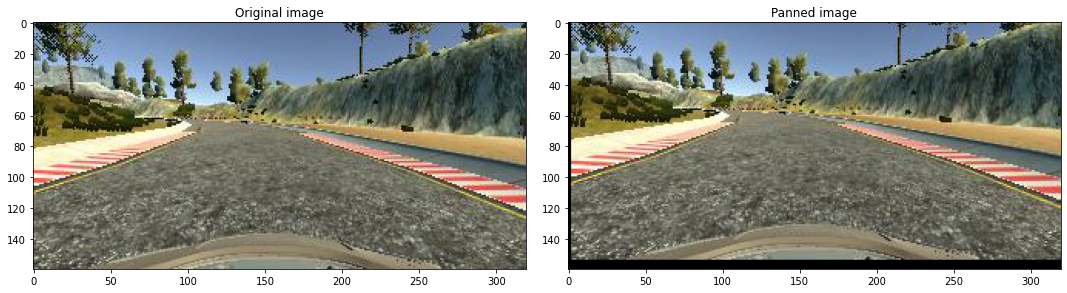

In [15]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
plt.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title('Original image')
ax[1].imshow(panned_image)
ax[1].set_title('Panned image')

In [16]:
def img_random_brightness(image):
  # nhân image với số thập phân ngẫu nhiên ( bé hơn 1 => darker, lớn hơn 1 => brighter)
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'Brightness alterd image')

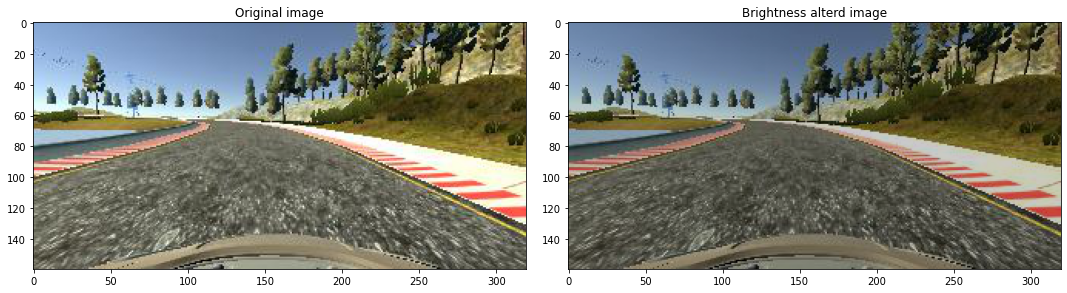

In [17]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_alterd_image = img_random_brightness(original_image)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
plt.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title('Original image')
ax[1].imshow(brightness_alterd_image)
ax[1].set_title('Brightness alterd image')

In [18]:
def img_random_flip(image, steering_angle):
  # 0 là veritical flip, 1 là horizontal flop, -1 là combine cả 2 
  image = cv2.flip(image, 1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'Flipped image - Steering_angle: 0.040151099999999995')

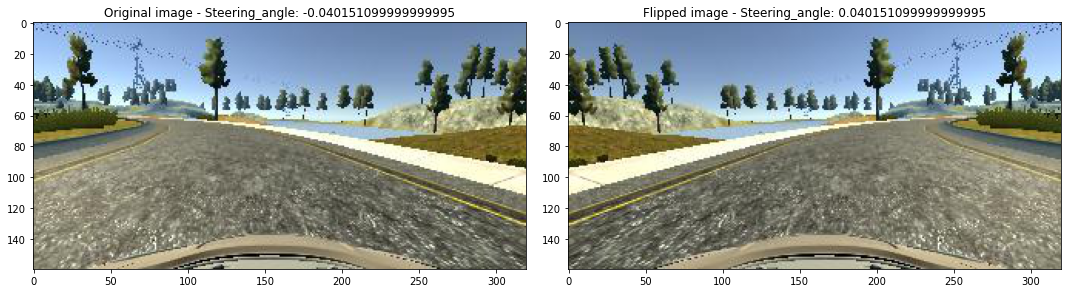

In [19]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]
original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
plt.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title('Original image - ' + 'Steering_angle: ' + str(steering_angle))
ax[1].imshow(flipped_image)
ax[1].set_title('Flipped image - '+ 'Steering_angle: ' + str(flipped_steering_angle))

In [20]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  # tỉ lệ phần trăm thực hiện augmentation là 50%
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

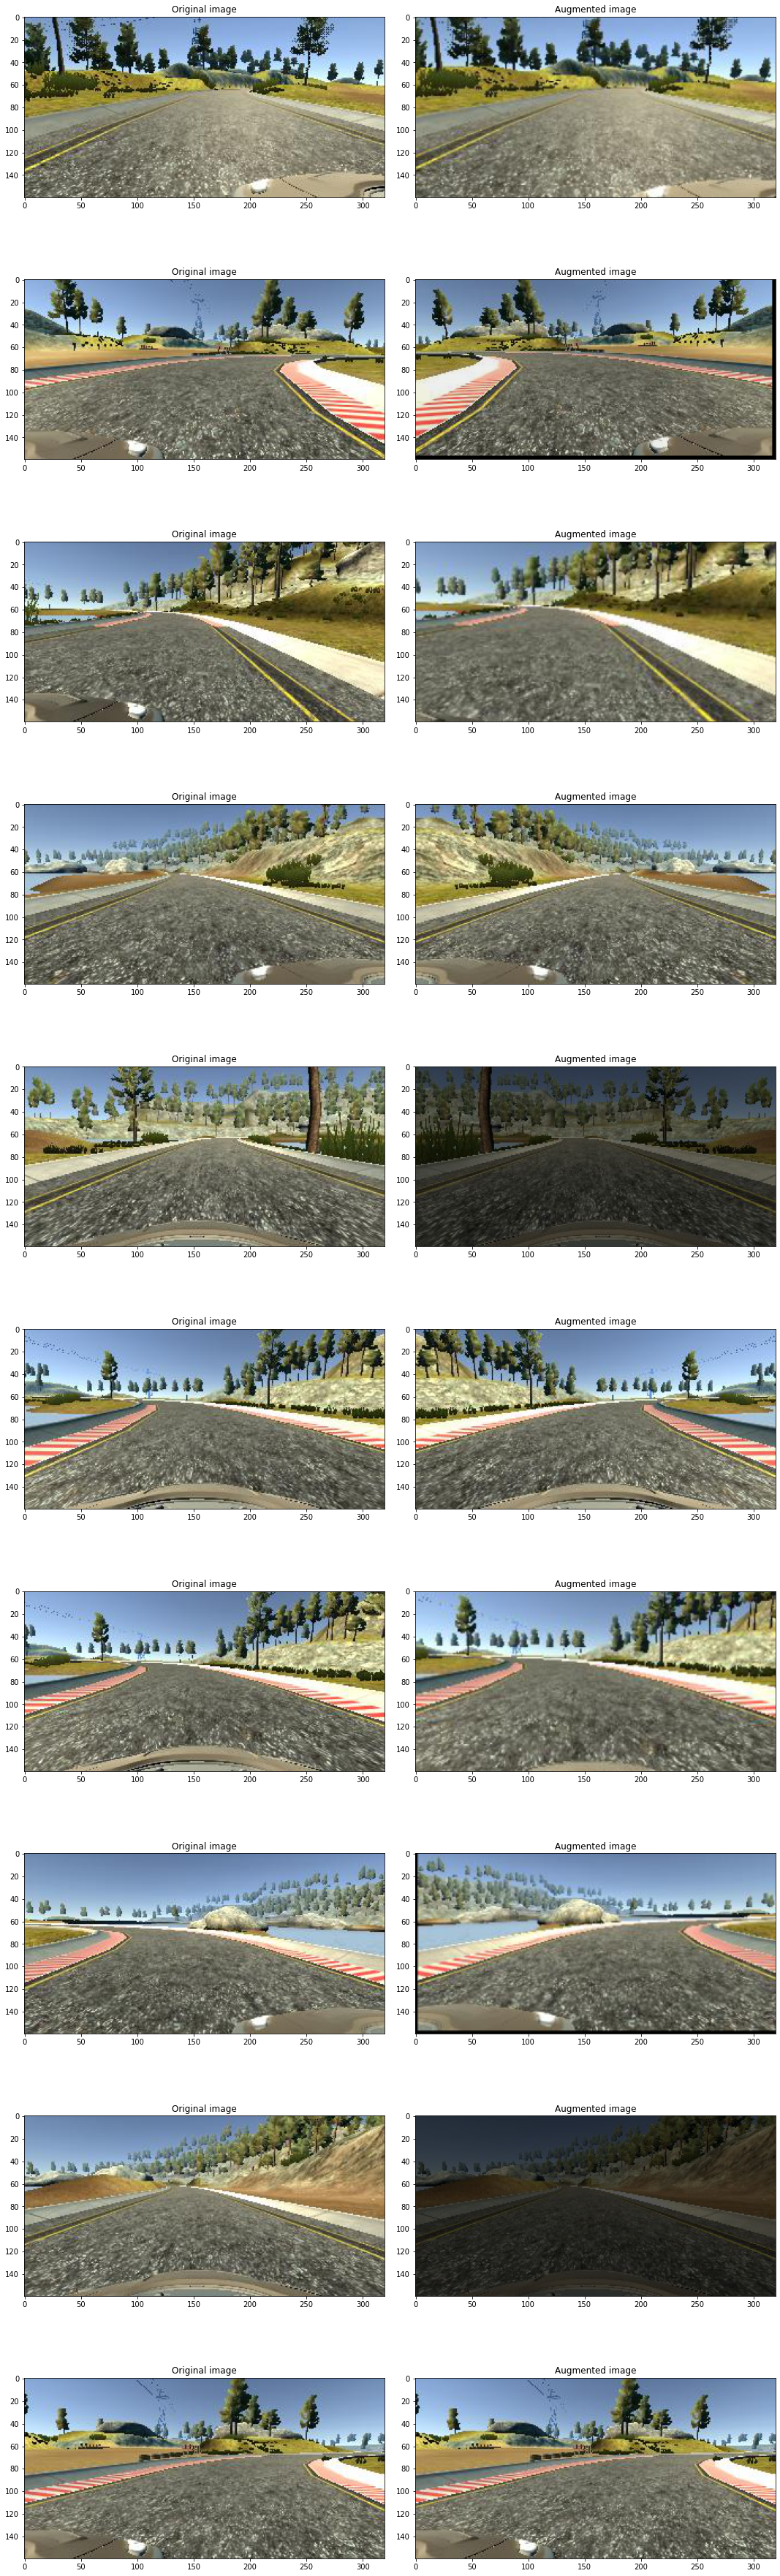

In [21]:
fig, ax = plt.subplots(nrows=10, ncols=2, figsize=(15,50))
fig.tight_layout()
for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)
  ax[i][0].imshow(original_image)
  ax[i][0].set_title('Original image')
  ax[i][1].imshow(augmented_image)
  ax[i][1].set_title('Augmented image')

In [22]:
# Tiền xử lí ảnh đầu vào để đưa vào Nvidia Model
def img_preprocess(img):
    # img = mpimg.imread(img)  # đọc ảnh, img là một đường dẫn tới folder chứ image
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

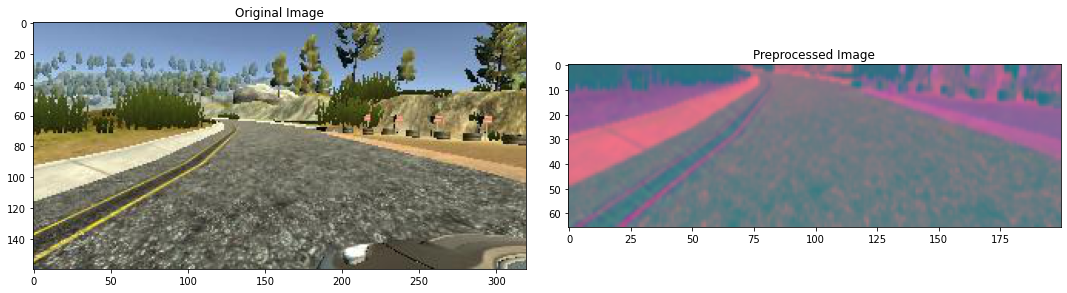

In [23]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)
fig, ax = plt.subplots(1, 2, figsize=(15,10))
plt.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(preprocessed_image)
ax[1].set_title('Preprocessed Image')

In [24]:
# tạo batch generator lưu trữ image trong batches để tiết kiệm memory
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []
    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths)-1)
      if istraining: # istraining =1 chỉ augmentation tập training data
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else: # istraining =0 không augmentation tập validation data
        im = mpimg.imread(image_paths[random_index]) 
        steering = steering_ang[random_index]
      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    # sử dụng yield vì sau mỗi vòng while vẫn sẽ lưu lại các biến cũ image và steering
    yield (np.asarray(batch_img), np.asarray(batch_steering)) 

Text(0.5, 1.0, 'Validation image')

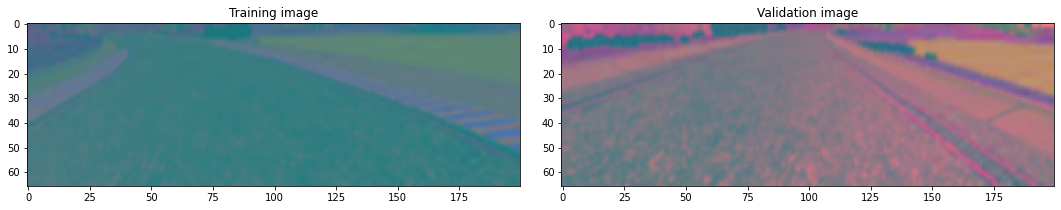

In [25]:
# visualize training và validation image để so sánh
X_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1)) # next dùng để lưu trữ các biến sau mỗi vòng l
X_val_gen, y_val_gen = next(batch_generator(X_val, y_val, 1, 0))
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
plt.tight_layout()
ax[0].imshow(X_train_gen[0])
ax[0].set_title('Training image')
ax[1].imshow(X_val_gen[0])
ax[1].set_title('Validation image')

In [26]:
# xây dựng nvidia model
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(filters=24, kernel_size=(5,5), input_shape=(66,200,3), strides=(2,2), activation='elu')) 
    model.add(Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='elu'))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='elu'))
    #model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(100, activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    #model.add(Dropout(0.5))

    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=1e-3), loss='mse')
    return model

In [27]:
model = nvidia_model()
# print(model.summary())
h = model.fit(batch_generator(X_train, y_train, batch_size=150, istraining=1), 
              steps_per_epoch=300, 
              validation_data=batch_generator(X_val, y_val, batch_size=100, istraining=0), 
              validation_steps=200, 
              epochs=10, 
              verbose=1, 
              shuffle=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
300/300 [==============================] - 340s 1s/step - loss: 0.1404 - val_loss: 0.0829
Epoch 2/10
300/300 [==============================] - 305s 1s/step - loss: 0.0789 - val_loss: 0.0736
Epoch 3/10
300/300 [==============================] - 302s 1s/step - loss: 0.0707 - val_loss: 0.0593
Epoch 4/10
300/300 [==============================] - 299s 998ms/step - loss: 0.0675 - val_loss: 0.0567
Epoch 5/10
300/300 [==============================] - 295s 987ms/step - loss: 0.0586 - val_loss: 0.0471
Epoch 6/10
300/300 [==============================] - 297s 994ms/step - loss: 0.0509 - val_loss: 0.0440
Epoch 7/10
300/300 [==============================] - 294s 982ms/step - loss: 0.0481 - val_loss: 0.0387
Epoch 8/10
300/300 [==============================] - 294s 984ms/step - loss: 0.0463 - val_loss: 0.0403
Epoch 9/10
300/300 [==============================] - 295s 986ms/step - loss: 0.0434 - val_loss: 0.0382
Epoch 10/10
300/300 [==============================] - 299s 1000ms/step -

Text(0.5, 1.0, 'Loss')

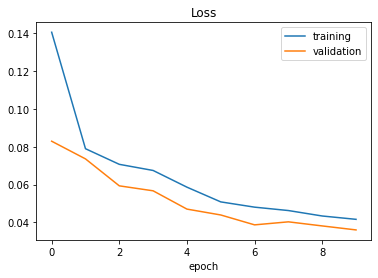

In [28]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.title('Loss')

In [29]:
model.save('model.h5')

In [30]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>